# Feature Engineering and Preprocessing

Firstly we'll drop features as we did in EDA, then encode where necessary, and then engineer if any features available.

After that we'll try a multitude of models to select the best performing model (likely using AUC). I expect I will experiment with:

* Decision Tree
* Random Forest
* XGBoost
* Logistic Regression
* SVM (Cost Penalising)

In [109]:
# imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# ML imports

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, log_loss, classification_report)
import xgboost

In [110]:
df_main = pd.read_csv('HR-Employee-Attrition.csv')

In [111]:
df_main.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


### Dropping Columns (same as EDA)

In [112]:
df_main.drop(labels=['EmployeeCount', 'EmployeeNumber','StandardHours','Over18'], axis=1,inplace=True)

### Dropping Additional Columns (from Correlation Matrix)

In [113]:
df_main.drop(labels=['YearsAtCompany', 'JobLevel'],axis=1,inplace=True)

In [114]:
len(df_main.columns)

29

### Encode categorical data

In [115]:
categorical_data = df_main.dtypes.loc[df_main.dtypes=='object'].index

print(", ".join(categorical_data))

Attrition, BusinessTravel, Department, EducationField, Gender, JobRole, MaritalStatus, OverTime


In [116]:
# get dummies function in Pandas performs one hot encoding
# making sure to drop_first to avoid collinearity issues
# use on everything except BusinessTravel (as we can rank this)

# business travel

business_encode_mask = {'Attrition':{'Yes':1,'No':0},'BusinessTravel': {'Travel_Frequently':2, 'Travel_Rarely':1,'Non-Travel':150}}
df_main.replace(business_encode_mask, inplace=True)

# now let's encode everything else

categorical_data = list(categorical_data)
categorical_data.remove('BusinessTravel')
categorical_data.remove('Attrition')


df_main = pd.get_dummies(df_main,columns=categorical_data, drop_first=True)

In [117]:
# let's sense check length to make sure all encoding went through

len(df_main.columns)

42

In [118]:
# makes sense, previously 29 + 1 for attrition + 2 for department + 5 for education field + 3 for job role + 1 for marital + 1 for ot

# let's now re-name into x and y

y = df_main['Attrition']
x = df_main.drop('Attrition',axis=1)

### Data transformation

Given the different scales seen within the quantitiatve data (from rank data 0 to 5) all the way to monthly income going up to $12k, we will need to transform this data.

Once again, I have referred to <a href='https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/'> here</a>.

I will implement normalisation for this case (and if I have enough time I will run some tests against standardisation for effectiveness)

In [119]:
from sklearn.preprocessing import normalize

x = normalize(x)

### Splitting between Test and Training

Let's split between test and training datasets now that we're preprocessed.


In [120]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.25, random_state=2)  
print("Number records X_train dataset: ", X_train.shape)
print("Number records y_train dataset: ", y_train.shape)
print("Number records X_test dataset: ", X_test.shape)
print("Number records y_test dataset: ", y_test.shape)

Number records X_train dataset:  (1102, 41)
Number records y_train dataset:  (1102,)
Number records X_test dataset:  (368, 41)
Number records y_test dataset:  (368,)


### Dealing with Imbalance

This is my first time dealing with imbalance so I refer to this friendly article I've reviewed <a href='https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/'>here</a>.

In summary, we try and 'rebalance' the dataset by making up fake records, either by oversampling (duplicating minority class, in this case, the leavers) or undersampling (deleting the majority class, or in this case, the non-leavers).

There is a package called 'imblearn' which uses some more sophisticated sampling techniques to rebalance.

In summary it looks like 'over-sampling' techniques generally outperform 'under-sampling' as it retains data. We will go with one called SMOTE. The article has a great write-up on it.


In [104]:
from imblearn.over_sampling import SMOTE

In [126]:
smote = SMOTE()

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print('Previous x shape {}. Current x shape: {}'.format(X_train.shape,X_train_smote.shape))
print('Previous y shape {}. Current y shape: {}'.format(y_train.shape,y_train_smote.shape))
print('\nPrevious y value counts: \n\n{}.\n\n Current y shape: \n\n{}'.format(y_train.value_counts(),y_train_smote.value_counts()))

Previous x shape (1102, 41). Current x shape: (1854, 41)
Previous y shape (1102,). Current y shape: (1854,)

Previous y value counts: 

0    927
1    175
Name: Attrition, dtype: int64.

 Current y shape: 

0    927
1    927
Name: Attrition, dtype: int64


# Machine Learning Models!

## Decision Tree


In [172]:
from sklearn import tree
import re

decision_tree = tree.DecisionTreeClassifier(max_depth = 4, random_state=2)
decision_tree.fit(X_train_smote, y_train_smote)

y_pred = decision_tree.predict(X_test)

# visualise the tree
print(tree.export_text(decision_tree, decimals=10,feature_names=list(df_main.drop('Attrition',axis=1).columns)))

|--- OverTime_Yes <= 0.0000001395
|   |--- MaritalStatus_Single <= 0.0000002754
|   |   |--- Department_Sales <= 0.0000001574
|   |   |   |--- TotalWorkingYears <= 0.0028144764
|   |   |   |   |--- class: 0
|   |   |   |--- TotalWorkingYears >  0.0028144764
|   |   |   |   |--- class: 1
|   |   |--- Department_Sales >  0.0000001574
|   |   |   |--- Department_Research & Development <= 0.0000008427
|   |   |   |   |--- class: 0
|   |   |   |--- Department_Research & Development >  0.0000008427
|   |   |   |   |--- class: 1
|   |--- MaritalStatus_Single >  0.0000002754
|   |   |--- StockOptionLevel <= 0.0000003845
|   |   |   |--- MonthlyIncome <= 0.1017170772
|   |   |   |   |--- class: 1
|   |   |   |--- MonthlyIncome >  0.1017170772
|   |   |   |   |--- class: 0
|   |   |--- StockOptionLevel >  0.0000003845
|   |   |   |--- class: 1
|--- OverTime_Yes >  0.0000001395
|   |--- MaritalStatus_Single <= 0.0000002106
|   |   |--- OverTime_Yes <= 0.0000344659
|   |   |   |--- BusinessTravel 

In [174]:
# let's have a look at classification

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       306
           1       0.46      0.39      0.42        62

    accuracy                           0.82       368
   macro avg       0.67      0.65      0.66       368
weighted avg       0.81      0.82      0.81       368



In [177]:
## Random Forest

random_forest = RandomForestClassifier(random_state=2)

random_forest.fit(X_train_smote, y_train_smote)

y_pred = random_forest.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.97      0.92       306
           1       0.71      0.32      0.44        62

    accuracy                           0.86       368
   macro avg       0.80      0.65      0.68       368
weighted avg       0.85      0.86      0.84       368



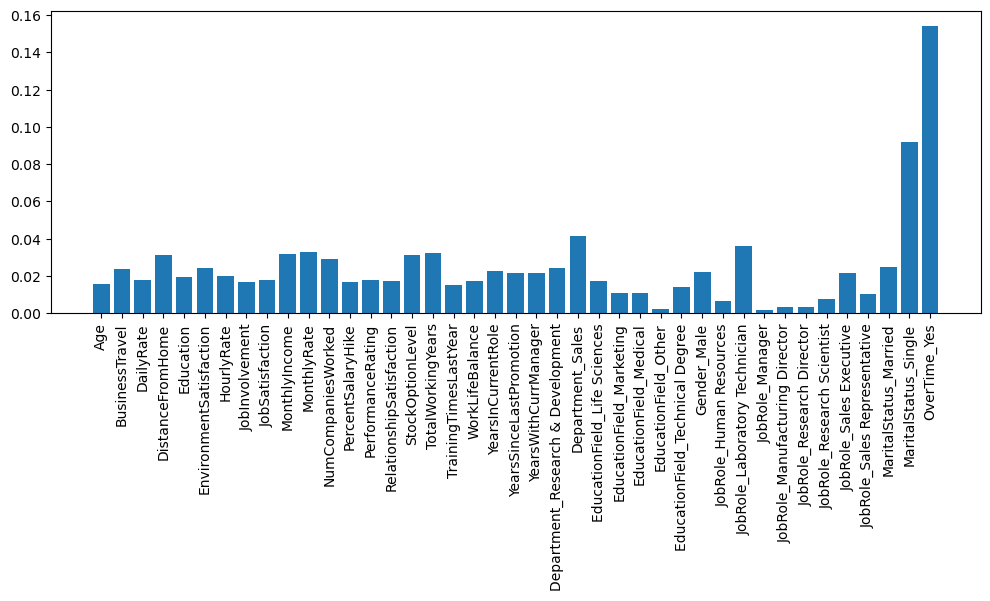

In [204]:
# Let's visualise feature importance

fig, ax = plt.subplots(1,1,figsize=(12,4),dpi=100)

ax.bar(x=list(df_main.drop('Attrition',axis=1).columns),height=random_forest.feature_importances_)
plt.xticks(rotation=90)

plt.show()


### XGBoost

In [210]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

xgb.fit(X_train_smote, y_train_smote)

y_pred = xgb.predict(X_test)

print(classification_report(y_test, y_pred))

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:45:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       306
           1       0.60      0.34      0.43        62

    accuracy                           0.85       368
   macro avg       0.74      0.65      0.67       368
weighted avg       0.83      0.85      0.83       368



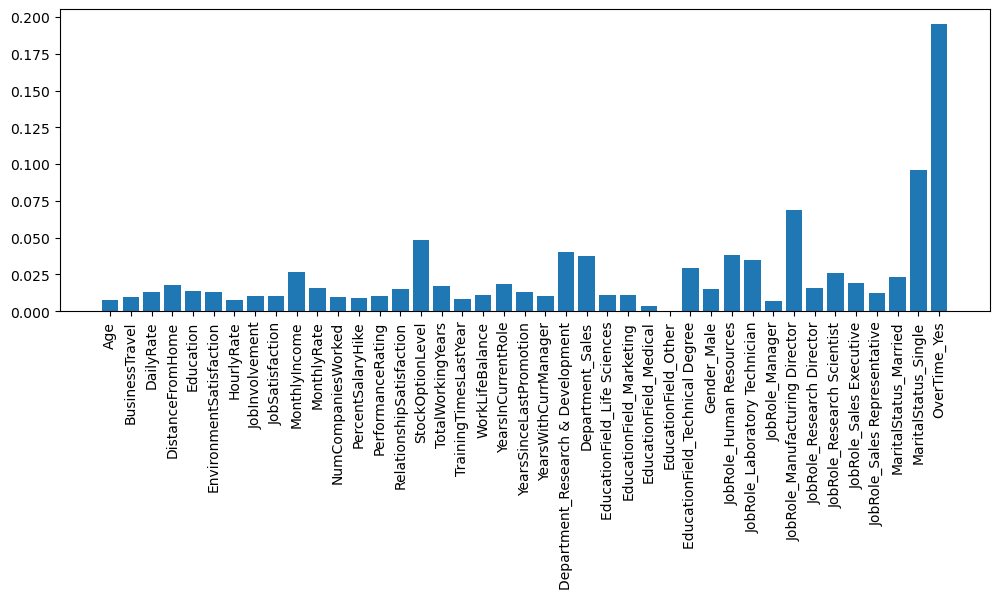

In [219]:
fig, ax = plt.subplots(1,1,figsize=(12,4),dpi=100)

ax.bar(x=list(df_main.drop('Attrition',axis=1).columns),height=xgb.feature_importances_)
plt.xticks(rotation=90)

plt.show()